In [1]:
#%matplotlib inline
import csv
import math
import random
from matplotlib import pyplot as plt

In [2]:
def retrieveData():
    data = list(csv.reader(open('test1.csv')))
    for i in data:
        i[0] = float(i[0])
        i[1] = float(i[1])
    lattitude = [i[0] for i in data]
    longitude = [i[1] for i in data]
    coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
    places = [i[2] for i in data]
    return coordinates, places

def retrievePreviousData():
    data = list(csv.reader(open('prevTour.csv')))
    return data


In [5]:
class ACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            exploration = random.uniform(0.0,1.0)
            if exploration < 0.10: #randomly explore
                min = float("inf")
                for unvisited_node in unvisited_nodes:
                    if self.edges[self.tour[-1]][unvisited_node].weight < min:
                        min = self.edges[self.tour[-1]][unvisited_node].weight
                        min_node = unvisited_node
                explored_node = min_node
                return explored_node
            else:
                roulette_wheel = 0.0
                for unvisited_node in unvisited_nodes: 
                    roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                      pow((1.0 / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                random_value = random.uniform(0.0, 1.0)
                wheel_position = 0.0
                for unvisited_node in random.sample(unvisited_nodes,len(unvisited_nodes)):
                    wheel_position += (pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                      pow((1.0 / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)) / roulette_wheel
                    if wheel_position >= random_value:
                        return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    #step size = 200
    def __init__(self, mode='Ant Colony System', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, jump_pheromone=1.5, steps=200, nodes=None, labels=None, previous_path=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        if previous_path != None:
            for i in range(len(previous_path)):
                if (previous_path[i-1] in labels) and (previous_path[i] in labels):
                    for j in range(len(labels)): #find index-1
                        if previous_path[i-1] == labels[j]:
                            for k in range(len(labels)):#find index-2
                                if previous_path[i] == labels[k]:
                                    self.edges[j][k].pheromone = jump_pheromone
                                    self.edges[k][j].pheromone = jump_pheromone
        
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _elitist_acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def run(self):
        self._elitist_acs()
        print('Route Sequence: {0} '.format(','.join(str(self.labels[i]) for i in self.global_best_tour)),'\n')
        csv_str = [self.labels[i] for i in self.global_best_tour]
        with open("prevTour.csv",'w') as resultFile:
            wr = csv.writer(resultFile, dialect='excel')
            wr.writerow(csv_str)
        print('Distance of tour: {0}\n'.format(round(self.global_best_distance, 2)))

    def sketch(self, line_width=1.5, point_radius=math.sqrt(2.5), annotation_size=15, dpi=120, save=True, name=None):
        img = plt.imread('ny-map.jpg')
        fig, ax = plt.subplots()
        ax.imshow(img, extent=[-455, 705, -455, 405])
        x = [self.nodes[i][0] for i in self.global_best_tour]
        x.append(x[0])
        y = [self.nodes[i][1] for i in self.global_best_tour]
        y.append(y[0])
        plt.plot(x, y, linewidth=line_width, color='blue')
        plt.scatter(x, y, s=math.pi * (point_radius ** 5.0), color='firebrick')
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.title(self.mode)
        for i in self.global_best_tour:
            plt.annotate(self.labels[i], self.nodes[i], size=annotation_size, color='navy')
        if save:
            if name is None:
                name = '{0}_tour2.png'.format(self.mode)
            plt.savefig(name, dpi=dpi)
        plt.show()
        plt.gcf().clear()

Route Sequence:  T, c, Q, G, H, S, m, ~, K, {, n, W, l, |, ^, Y, o, A, b, q, \, J, i, N, I, O, L, w, v, U, x, j, z, D, ], e, _, p, `, a, P, R, u, r, X, }, V, Z, h, t, s, y, E, k, B, f, M, g, d, C, [, F  

Distance of tour: 5765.99



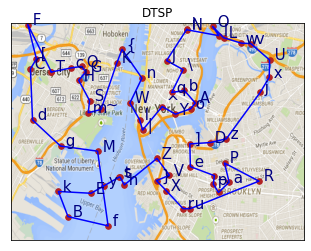

<Figure size 432x288 with 0 Axes>

In [6]:
if __name__ == '__main__':
    coordinates, places = retrieveData()
    previous_data = retrievePreviousData()
    _colony_size = 20
    _steps = 350
    _nodes = coordinates
    elitist_instance = ACO(mode='DTSP', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places, previous_path=previous_data)
    elitist_instance.run()
    elitist_instance.sketch()

In [39]:
import csv
data = list(csv.reader(open('datafile.csv')))
for i in data:
    i[0] = float(i[0])
    i[1] = float(i[1])
lattitude = [i[0] for i in data]
longitude = [i[1] for i in data]
coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
places = [i[2] for i in data]
print (data)
print('lattitude: ', lattitude)
print('longitude: ', longitude)
print('coordinates: ', coordinates)
print('places: ', places)

[[300.0, 200.0, 'Office'], [-300.0, 150.0, 'Plant'], [-200.0, 300.0, 'Home'], [20.0, -350.0, 'Park'], [-25.0, 220.0, 'Garage'], [25.0, 84.0, 'Work'], [210.0, -97.0, 'Factory'], [215.0, 34.0, 'A'], [3.0, 45.0, 'B'], [-350.0, -350.0, 'C'], [78.8082523072, -277.584758819, ' a'], [-241.860995569, 240.378896381, ' b'], [323.343785709, 37.0648945699, ' c'], [36.304777219, -388.104545099, ' d'], [220.411659417, 89.4733712635, ' e']]
lattitude:  [300.0, -300.0, -200.0, 20.0, -25.0, 25.0, 210.0, 215.0, 3.0, -350.0, 78.8082523072, -241.860995569, 323.343785709, 36.304777219, 220.411659417]
longitude:  [200.0, 150.0, 300.0, -350.0, 220.0, 84.0, -97.0, 34.0, 45.0, -350.0, -277.584758819, 240.378896381, 37.0648945699, -388.104545099, 89.4733712635]
coordinates:  [[300.0, 200.0], [-300.0, 150.0], [-200.0, 300.0], [20.0, -350.0], [-25.0, 220.0], [25.0, 84.0], [210.0, -97.0], [215.0, 34.0], [3.0, 45.0], [-350.0, -350.0], [78.8082523072, -277.584758819], [-241.860995569, 240.378896381], [323.343785709,

In [40]:
#Create Data Points (coordinates and locations)
import random 
A=400*random.random()

for i in range(62):
    print (random.uniform(-400, 600),',', random.uniform(-400, 400),',', chr(65+i))

130.99343466789423 , -20.213901591640592 , A
342.0724384575261 , -207.96594261546204 , B
109.11363930662856 , -190.22620736945893 , C
17.713757654610845 , 50.088628257285336 , D
-378.11284587638215 , 67.43857299639052 , E
267.8534463537443 , -361.9409889166425 , F
-250.13049682864937 , 226.57194591935684 , G
18.85734392758178 , -153.61526384910792 , H
536.0889323879079 , 309.4289440906101 , I
-123.57472809576848 , 189.77130869457142 , J
-328.0606365778704 , -131.1447781486936 , K
539.5025448128504 , 267.304752927889 , L
243.7618572542949 , 265.3075283634274 , M
142.5482131684089 , 362.7604059636167 , N
32.913286273032725 , -136.91632371302688 , O
-347.7874145575187 , 137.14798461461294 , P
275.7571514744228 , 355.49865340721226 , Q
-196.9152802549465 , -293.7883225940258 , R
533.9557980945298 , -223.01864672088652 , S
277.67334994549844 , -328.215105414484 , T
-181.2538583191444 , -171.87899674165843 , U
394.569155008685 , -197.42768928845686 , V
-354.1168039554117 , 145.23785213380495

In [41]:
#Create Data Points (coordinates and locations)
import random 
A=400*random.random()

for i in range(62):
    print (random.uniform(-400, 600),',', random.uniform(-400, 400),',', chr(65+i))

50.04425021708596 , -76.19914454087831 , A
342.30230620996167 , 199.10434282551478 , B
51.28102281070079 , 353.22223252801507 , C
548.1088015497737 , 126.13611361930498 , D
-179.08738493044083 , 35.34496450959762 , E
-343.4463327066118 , 102.45222970122433 , F
348.8843320388172 , -25.267565814386217 , G
427.3233605949931 , -269.8142776496571 , H
261.67443372714047 , -220.1838011867306 , I
80.83359264220593 , -88.4894181213449 , J
-119.46180274273416 , -0.8874791207791191 , K
342.9767701214264 , -321.9007283616154 , L
-7.945297975000756 , 122.42784577604334 , M
497.55737339307734 , -79.88151632072629 , N
188.25931150441727 , -193.14453314021353 , O
230.48900936055895 , 109.47888195759452 , P
-347.4201253904951 , 328.4422709570839 , Q
596.6639768763312 , 373.404109489083 , R
-389.19660177771027 , 399.94654550499126 , S
273.948324276765 , 343.13018910797507 , T
-69.5405573149311 , -33.12302060740137 , U
495.64119382369313 , -165.49174452627744 , V
17.646677528174735 , 388.10291564966974 ,

In [42]:
#Create Data Points (coordinates and locations)


import csv
import random 
count = 62
random_coordinates = [[] for i in range(count)]
for i in range(count):
    random_coordinates[i].append(random.uniform(-400, 600))
    random_coordinates[i].append(random.uniform(-400, 400))
    random_coordinates[i].append(chr(65+i))
    print(random_coordinates[i])

with open('test2.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(random_coordinates)
count = 0

[-68.02015032029459, -267.8654125749483, 'A']
[-252.33731159319902, -343.22005830018963, 'B']
[240.0749440635684, -322.2548703492862, 'C']
[204.15931823140716, 137.41170134559138, 'D']
[24.88484652879987, 327.38189563275114, 'E']
[-363.1441322243542, 225.92772810896247, 'F']
[119.72451986253247, -65.7353450326591, 'G']
[50.27586578641876, -36.87572872156329, 'H']
[573.4758027057981, 324.69971138594497, 'I']
[271.7293409564385, -131.74557341419984, 'J']
[192.8215725686997, 197.93095776707764, 'K']
[314.4440721491194, 272.0435569521387, 'L']
[406.7798334336211, 41.349948496049024, 'M']
[282.9662064062967, -393.7808731764332, 'N']
[119.08113664059204, -309.13951875645284, 'O']
[107.07878912974002, -135.58264903101423, 'P']
[272.0895904890798, -275.8824063178488, 'Q']
[-11.082824274818506, -235.93767253019422, 'R']
[473.1249777740999, -186.38015291278745, 'S']
[398.21156771013284, -379.3047568187235, 'T']
[404.28085934963724, 251.85090112975774, 'U']
[382.5180553664085, -292.5987696270113,

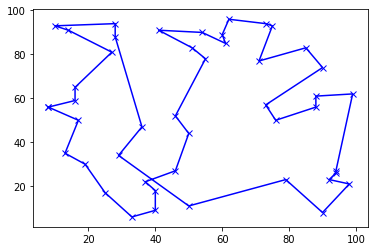

<Figure size 432x288 with 0 Axes>

In [46]:
import random, numpy, math, copy, matplotlib.pyplot as plt
cities = [random.sample(range(100), 2) for x in range(45)];
tour = random.sample(range(45),45);
for temperature in numpy.logspace(0,5,num=100000)[::-1]:
    [i,j] = sorted(random.sample(range(45),2));
    newTour =  tour[:i] + tour[j:j+1] +  tour[i+1:j] + tour[i:i+1] + tour[j+1:];
    if math.exp( ( sum([ math.sqrt(sum([(cities[tour[(k+1) % 45]][d] - cities[tour[k % 45]][d])**2 for d in [0,1] ])) for k in [j,j-1,i,i-1]]) - sum([math.sqrt(sum([(cities[newTour[(k+1) % 45]][d] - cities[newTour[k % 45]][d])**2 for d in [0,1] ])) for k in [j,j-1,i,i-1]])) / temperature) > random.random():
        tour = copy.copy(newTour);
plt.plot(list(zip(*[cities[tour[i % 45]] for i in range(46) ]))[0], list(zip(*[cities[tour[i % 45]] for i in range(46) ]))[1], 'xb-', );
plt.show()
plt.savefig('pic.png')